# Supply chain network
[![supply_chain_simple_routes.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/supply_chain_simple_routes.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/supply_chain_simple_routes.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/supply_chain_simple_routes.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/supply_chain_simple_routes.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/supply_chain_simple_routes.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/marcos-dv/supply_chain/supply_chain_simple_routes.ipynb)](https://colab.ampl.com)

Description: Compute optimal routes to connect suppliers/demanding nodes in a network. Routes have an associated fixed and variable cost. There are different products to ship. The problem is formulated as a MIP with binary variables. Python data structures are used to load the data into the model.

Tags: mixed-integer-linear, supply_chain, network, transportation, graphs

Notebook author: Marcos Dominguez Velad <<marcos@ampl.com>>

Model author: N/A


In [1]:
# Install dependencies
%pip install -q amplpy pandas numpy matplotlib networkx

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["open"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

This notebook explores the formulation of a transhippment model where routes between origin and destination nodes need to be determined to send products, while minimizing routing costs (there are fixed + variable costs per route).

There are different kinds of products, suppliers can send to multiple destination nodes, and the final nodes can receive products from different nodes. Only edges between origin and destinations are considered in the network. The example is inspired by the multicommodity transportation example from the AMPL book.

After finding the optimal solution, we are displaying a simple graph with it through the [networkx](https://networkx.org) package.

We are using [amplpy](https://amplpy.ampl.com) to formulate the problem and solve it with the MIP solver [highs](https://highs.dev).

This notebook can run on google colab with an ampl community edition for free without size limits.

## Model

There are a set of *origin* nodes, a set of *destination* nodes, and products to be demanded/supplied from origins to destinations.

* Sets:
    * `ORIG`: origin cities that supply products.
    * `DEST`: final cities that demand and receive products.
    * `PROD`: set of products to deliver.
* Parameters:
    * `supply {ORIG,PROD}`: amounts of product available at origins.
    * `demand {DEST,PROD}`: amounts required at destinations.
    * `limit`: maximum capacity on routes between two nodes.
    * `vcost {ORIG,DEST,PROD}`: variable shipment cost on routes that depends on the units of product sent.
    * `fcost {ORIG,DEST}`: fixed cost for using a route.
* Variables:
    * `Trans {ORIG,DEST,PROD}`: units to be shipped.
    * `Use {ORIG,DEST}`: **binary** variable equals to 1 if route is used, 0 otherwise.
* Objective: minimize total cost.

$$ \sum \limits_{\substack{i \in ORIG \\ j \in DEST \\ p \in PROD}} vcost[i,j,p] \cdot Trans[i,j,p]
 + \sum \limits_{\substack{i \in ORIG \\ j \in DEST}} fcost[i,j] \cdot Use[i,j]$$

* Constraints:
    * `Supply {ORIG,PROD}`: node ships units equal to supply capacity
    
    $$\sum \limits_{j \in DEST} Trans[i,j,p] = supply[i,p]$$
    
    * `Demand {DEST,PROD}`: node gets units equal to demand
    
    $$\sum \limits_{i \in ORIG} Trans[i,j,p] = demand[j,p]$$
    
    * `Multi {ORIG,DEST}`: links capacity is bounded
    
    $$\sum \limits_{p \in PROD} Trans[i,j,p] \leq limit \cdot Use[i,j]$$

In [3]:
%%writefile supply_chain.mod
set ORIG;   # origins
set DEST;   # destinations
set PROD;   # products

param supply {ORIG,PROD} >= 0;  # amounts available at origins
param demand {DEST,PROD} >= 0;  # amounts required at destinations

   check {p in PROD}:
      sum {i in ORIG} supply[i,p] = sum {j in DEST} demand[j,p];

param limit >= 0;   # maximum shipments on routes

param vcost {ORIG,DEST,PROD} >= 0; # variable shipment cost on routes
var Trans {ORIG,DEST,PROD} >= 0;   # units to be shipped

param fcost {ORIG,DEST} >= 0;      # fixed cost for using a route
var Use {ORIG,DEST} binary;        # = 1 only for routes used

minimize Total_Cost:
   sum {i in ORIG, j in DEST, p in PROD} vcost[i,j,p] * Trans[i,j,p]
 + sum {i in ORIG, j in DEST} fcost[i,j] * Use[i,j];

subject to Supply {i in ORIG, p in PROD}:
   sum {j in DEST} Trans[i,j,p] = supply[i,p];

subject to Demand {j in DEST, p in PROD}:
   sum {i in ORIG} Trans[i,j,p] = demand[j,p];

subject to Multi {i in ORIG, j in DEST}:
   sum {p in PROD} Trans[i,j,p] <= limit * Use[i,j];


Writing supply_chain.mod


Once we wrote the model in a file, use ampl to read it.

The `prepare_data()` function prepares the pythonic data structures so they can be used from ampl easily.

Finally, solve the model with highs and use the display statement to glance the solution.

In [4]:
import pandas as pd
import numpy as np

def prepare_data():
  origins = ['GARY', 'CLEV', 'PITT']
  destinations = ['FRA', 'DET', 'LAN', 'WIN', 'STL', 'FRE', 'LAF']
  products = ['bands', 'coils', 'plate']

  limit = 625

  supply_df = pd.DataFrame(
        np.array(
            [
                [400, 700, 800],
                [800, 1600, 1800],
                [200, 300, 300],
            ]
        ),
        columns=origins,
        index=products,
  ).T

  demand_df = pd.DataFrame(
        np.array(
            [
                [300,  300,  100,   75,  650,  225,  250],
                [500,  750,  400,  250,  950,  850,  500],
                [100,  100,    0,   50,  200,  100,  250],
            ]
        ),
        columns=destinations,
        index=products,
  ).T

  fixedcosts_df = pd.DataFrame(
        np.array(
            [
                [3000, 1200, 1200, 1200, 2500, 3500, 2500],
                [2000, 1000, 1500, 1200, 2500, 3000, 2200],
                [2000, 1200, 1500, 1500, 2500, 3500, 2200],
            ]
        ),
        columns=destinations,
        index=origins,
  )

  v_costs = {
    ('bands','GARY'): [30, 10, 8, 10, 11, 71, 6],
    ('bands','CLEV'): [22, 7, 10, 7, 21, 82, 13],
    ('bands','PITT'): [19, 11, 12, 10, 25, 83, 15],
    ('coils','GARY'): [39, 14, 11, 14, 16, 82, 8],
    ('coils','CLEV'): [27, 9, 12, 9, 26, 95, 17],
    ('coils','PITT'): [24, 14, 17, 13, 28, 99, 20],
    ('plate','GARY'): [41, 15, 12, 16, 17, 86, 8],
    ('plate','CLEV'): [29, 9, 13, 9, 28, 99, 18],
    ('plate','PITT'): [26, 14, 17, 13, 31, 104, 20]
  }

  v_costs_dict = {(orig, destinations[i], prod):v for (prod, orig) in v_costs.keys() for i,v in enumerate(v_costs[prod,orig])}

  return origins, destinations, products, supply_df, demand_df, limit, fixedcosts_df, v_costs_dict



# read model
ampl.read('supply_chain.mod')
# get data
origins, destinations, products, supply, demand, limit, fixedcosts, variablecosts = prepare_data()
# load data into ampl
ampl.set['ORIG'] = origins
ampl.set['DEST'] = destinations
ampl.set['PROD'] = products
ampl.param['supply'] = supply
ampl.param['demand'] = demand
ampl.param['limit'] = limit
ampl.param['fcost'] = fixedcosts
ampl.param['vcost'] = variablecosts

# solve with highs
ampl.solve(solver='highs')
ampl.option['display_eps'] = 1e-6;
ampl.display('Use, Trans')

HiGHS 1.7.0: HiGHS 1.7.0: optimal solution; objective 229850
700 simplex iterations
1 branching nodes
absmipgap=0.806452, relmipgap=3.5086e-06
Use [*,*] (tr)
:   CLEV GARY PITT    :=
DET   1    0    1
FRA   1    0    1
FRE   0    1    1
LAF   1    0    1
LAN   1    1    0
STL   1    1    1
WIN   1    0    0
;

Trans [CLEV,*,*]
:   bands coils plate    :=
DET     0   525   100
FRA   275     0     0
FRE     0     0     0
LAF     0   375    50
LAN     0   350     0
STL   350   100   100
WIN    75   250    50

 [GARY,*,*]
:   bands coils plate    :=
DET     0     0     0
FRA     0     0     0
FRE     0   525   100
LAF     0     0     0
LAN   100    50     0
STL   300   225   100
WIN     0     0     0

 [PITT,*,*]
:   bands coils plate    :=
DET   300   225     0
FRA    25   500   100
FRE   225   325     0
LAF   250   125   200
LAN     0     0     0
STL     0   625     0
WIN     0     0     0
;



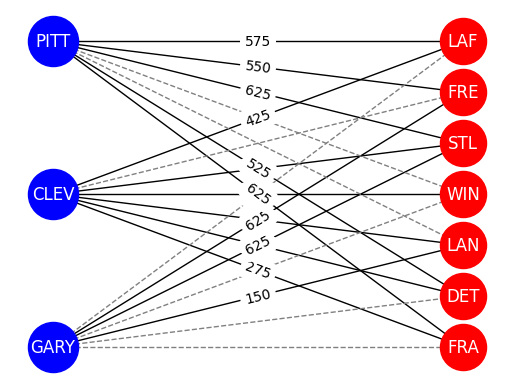

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# retrieve dictionaries from ampl with the solution
def retrieve_solution(model):
  use = model.var['Use'].to_dict()
  rounded_use = {key: float(round(value, 6)) for key, value in use.items()}

  supplied = model.getData('{i in ORIG, j in DEST} sum {p in PROD} Trans[i,j,p]').to_dict()
  rounded_supplied = {key: float(round(value, 6)) for key, value in supplied.items() if supplied[key] >= 5e-6}
  return rounded_use, rounded_supplied

# draw a graph to show the solution
def print_sol(sources, destinations, used_edges):
  unused_edges = [ (i,j) for i in sources for j in destinations if (i,j) not in used_edges.keys() ]

  # Create a bipartite graph
  G = nx.Graph()

  # Add source and destination nodes
  G.add_nodes_from(sources, bipartite=0)  # Set attribute bipartite to 0 for source nodes
  G.add_nodes_from(destinations, bipartite=1)  # Set attribute bipartite to 1 for destination nodes

  # Add continuous edges from sources to destinations
  for i,j in used_edges.keys():
    G.add_edge(i, j)

  # Create bipartite layout
  pos = nx.bipartite_layout(G, sources, align='vertical')

  # Draw continuous edges
  nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black')

  # Draw discontinuous edges
  nx.draw_networkx_edges(G, pos, edgelist=unused_edges, edge_color='grey', style='dashed')

  # Annotate edges with numbers
  supply_numbers = {key: int(value) for key, value in used_edges.items()}
  nx.draw_networkx_edge_labels(G, pos, edge_labels=supply_numbers)

  # Draw nodes and labels
  nx.draw_networkx_nodes(G, pos, nodelist=sources, node_color='blue', node_size=1300)
  nx.draw_networkx_nodes(G, pos, nodelist=destinations, node_color='red', node_size=1100)
  nx.draw_networkx_labels(G, pos, font_color='white')

  # Show plot
  plt.axis('off')
  plt.show()

used_edges, supplied = retrieve_solution(ampl)
print_sol(origins, destinations, supplied)